<h1>Dados Covid-19 - Pré-processamento</h1>

Dados obtidos do site <a href="https://brasil.io">Brasil.io</a>. O qual disponibiliza não apenas os dados como também documentação, diversas visualizações dos dados, uma API de acesso além do código fonte de tudo.

URL direta dos dados: <a href="https://brasil.io/dataset/covid19/files/">https://brasil.io/dataset/covid19/files/</a>.

Data de download: 02/03/2021.

<h2>Ajustando Dados</h2>

Carga da biblioteca gráfica:

In [1]:
library("ggplot2")

Carga dos dados.

In [2]:
dados <- read.csv("../input/covid19/caso.csv", header = TRUE, stringsAsFactors = FALSE)

Dados de Regiões de Saúde do Rio de Janeiro:
<img src="regioes_saude_habitantes_rj.png" />

In [3]:
regioes_saude <- read.csv("../input/covid19/regioes_saude.csv", header = TRUE, stringsAsFactors = FALSE)

Vamos manter apenas os dados necessários:

In [4]:
dados <- dados[dados$state == "RJ" & dados$place_type == "city", ]
dados <- dados[ , - c(2, 4, 9)] # state, place_type, estimated_population_2019
dados <- dados[dados$city != "Importados/Indefinidos", ]

Número de mortes por dia:

In [5]:
dados$deaths_day <- 0

municipios <- sort(unique(dados$city))

for (municipio in municipios) {
  indices <- sort(dados[dados$city == municipio, "order_for_place"])
  acumulado <- 0
  for (indice in indices) {
    mortes_no_dia <- dados[dados$city == municipio & dados$order_for_place == indice, "deaths"] - acumulado
    dados[dados$city == municipio & dados$order_for_place == indice, "deaths_day"] <- mortes_no_dia
    acumulado <- dados[dados$city == municipio & dados$order_for_place == indice, "deaths"]
  }
}

Média de mortes por semana:

In [6]:
# seleciona apenas colunas de interesse
temp <- dados[ , c("date", "city", "estimated_population", "deaths_day")]

# todas as datas que existem no conjunto de dados
datas <- sort(unique(temp$date))

# faz com que todos os municipios tenham dados de todas as datas (quando não tem coloca zero)
linha <- nrow(temp)
for (municipio in municipios) {
  populacao <- unique(temp[temp$city == municipio, "estimated_population"])
  for (data in datas) {
    if (nrow(temp[temp$city == municipio & temp$date == data,]) == 0) {
      linha <- linha + 1
      temp[(linha), "date"] <- data
      temp[(linha), "city"] <- municipio
      temp[(linha), "estimated_population"] <- populacao
      temp[(linha), "deaths_day"] <- 0 
    }
  }
}

temp$week <- 0

datas <- sort(unique(temp$date))

# Para cada data o numero de sua semana
for (municipio in municipios) {
  i <- 0
  for (data in datas) {
    temp[temp$city == municipio & temp$date == data, "week"] <- as.integer(i / 7) + 1
    i <- i + 1
  }
}

# Semanas, cidades e média de mortes de cada semana:
semanal <- data.frame(week = 0, city = "", mean_deaths_week = 0, estimated_population=0, stringsAsFactors = FALSE)

semanas <- sort(unique(temp$week))

i <- 1
for (municipio in municipios) {
  for (semana in semanas) {
    total <- sum(temp[temp$city == municipio & temp$week == semana, "deaths_day"])
    linhas <- nrow(temp[temp$city == municipio & temp$week == semana, ])
    semanal[i, "week"] <- semana
    semanal[i, "city"] <- municipio
    semanal[i, "mean_deaths_week"] <- total / linhas
    i <- i + 1
  }
  semanal[semanal$city == municipio, "estimated_population"] <- unique(temp[temp$city == municipio, "estimated_population"])
}

Anexando os dados de Regiões de Saúde do Rio de Janeiro:

In [7]:
semanal <- merge(semanal, regioes_saude, by="city", all.x=TRUE)

Agregando os dados por Regiões de Saúde:

In [8]:
agregado <- aggregate(semanal[ , c("mean_deaths_week", "estimated_population")], by = list(semanal$week, semanal$health_region), FUN = sum)
colnames(agregado) <- c("week", "health_region", "mean_deaths_week", "estimated_population")

Calculando a variação percentual:

In [9]:
agregado$percentage_change <- 0

regioes <- sort(unique(agregado$health_region))
semanas <- sort(unique(agregado$week))

for (regiao in regioes) {
  ultimas_semanas <- c(0, 0, 0)
  
  for (semana in semanas) {
    esta_semana <- agregado[agregado$health_region == regiao & agregado$week == semana, "mean_deaths_week"]
    ultimas_semanas[semana %% 3 + 1] <- esta_semana
    
    mudanca_percentual <- 0
    if (esta_semana != 0) {
      if (semana > 3) {
        mudanca_percentual <- esta_semana / ultimas_semanas[(semana + 1) %% 3 + 1] - 1
      } else {
        mudanca_percentual <- esta_semana / ultimas_semanas[2] - 1
      }
      
      if (is.infinite(mudanca_percentual)) {  # divisao por zero (Inf)?
        mudanca_percentual <- 0
      }
    }
    agregado[agregado$health_region == regiao & agregado$week == semana, "percentage_change"] <- mudanca_percentual
  }
}

<h2>Suavizando dados</h2>

Usamos funções obtidas no GitHub do professor <a href="https://eic.cefet-rj.br/~eogasawara/">Eduardo Ogasawara</a>:
https://github.com/eogasawara/mylibrary

Carregando as funções:

In [10]:
source("https://raw.githubusercontent.com/eogasawara/mylibrary/master/mySmoothing.R")
source("https://raw.githubusercontent.com/eogasawara/mylibrary/master/myClustering.R")

explore_smoothing <- function(obj, data, attribute) {
  obj <- prepare(obj, data)
  sl.bi <- action(obj, data)
  print(table(sl.bi))
  
  entro <- cluster_evaluation(as.factor(names(sl.bi)), attribute)
  print(paste0("Entropia = ", entro$entropy))
  
  return(sl.bi)
}

optimize_smoothing <- function(obj, data, attribute) {
  obj <- optimize(obj, data, do_plot=TRUE)
  explore_smoothing(obj, data, attribute)
}

Otimizar o número de divisões:

sl.bi
 -0.730995336989331  -0.339274661356296 -0.0355804755364314   0.277214796100946 
                 34                 102                 136                  61 
   0.59634194826929   0.939681865451803     1.2507244491338    3.39662438573275 
                 43                  25                  12                  55 


Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] "Entropia = 3.07175213202694"


3           3           3           3           3           3 
-0.03558048 -0.03558048 -0.03558048 -0.03558048 -0.03558048 -0.03558048 
          3           8           3           8           4           6 
-0.03558048  3.39662439 -0.03558048  3.39662439  0.27721480  0.93968187 
          3           6           3           1           1           2 
-0.03558048  0.93968187 -0.03558048 -0.73099534 -0.73099534 -0.33927466 
          8           5           1           3           7           3 
 3.39662439  0.59634195 -0.73099534 -0.03558048  1.25072445 -0.03558048 
          2           2           3           4           3           1 
-0.33927466 -0.33927466 -0.03558048  0.27721480 -0.03558048 -0.73099534 
          2           2           2           4           8           4 
-0.33927466 -0.33927466 -0.33927466  0.27721480  3.39662439  0.27721480 
          2           5           3           4           1           8 
-0.33927466  0.59634195 -0.03558048  0.27721480 -0.73099534  3.39662439 
          8           2           1           2           8           2 
 3.39662439 -0.33927466 -0.73099534 -0.33927466  3.39662439 -0.33927466 
          2           2           1           2           3           3 
-0.33927466 -0.33927466 -0.73099534 -0.33927466 -0.03558048 -0.03558048 
          3           3           6           8           4           5 
-0.03558048 -0.03558048  0.93968187  3.39662439  0.27721480  0.59634195 
          4           5           8           5           2           2 
 0.27721480  0.59634195  3.39662439  0.59634195 -0.33927466 -0.33927466 
          2           4           8           6           2           3 
-0.33927466  0.27721480  3.39662439  0.93968187 -0.33927466 -0.03558048 
          3           2           4           6           2           1 
-0.03558048 -0.33927466  0.27721480  0.93968187 -0.33927466 -0.73099534 
          2           6           4           3           3           3 
-0.33927466  0.93968187  0.27721480 -0.03558048 -0.03558048 -0.03558048 
          3           1           5           8           4           4 
-0.03558048 -0.73099534  0.59634195  3.39662439  0.27721480  0.27721480 
          2           5           5           1           4           8 
-0.33927466  0.59634195  0.59634195 -0.73099534  0.27721480  3.39662439 
          4           2           3           3           6           4 
 0.27721480 -0.33927466 -0.03558048 -0.03558048  0.93968187  0.27721480 
          3           4           3           3           3           3 
-0.03558048  0.27721480 -0.03558048 -0.03558048 -0.03558048 -0.03558048 
          3           3           6           5           8           5 
-0.03558048 -0.03558048  0.93968187  0.59634195  3.39662439  0.59634195 
          6           5           4           4           4           8 
 0.93968187  0.59634195  0.27721480  0.27721480  0.27721480  3.39662439 
          2           1           2           4           4           2 
-0.33927466 -0.73099534 -0.33927466  0.27721480  0.27721480 -0.33927466 
          2           4           2           1           3           8 
-0.33927466  0.27721480 -0.33927466 -0.73099534 -0.03558048  3.39662439 
          5           4           3           3           2           3 
 0.59634195  0.27721480 -0.03558048 -0.03558048 -0.33927466 -0.03558048 
          2           3           1           5           8           6 
-0.33927466 -0.03558048 -0.73099534  0.59634195  3.39662439  0.93968187 
          5           3           2           2           3           3 
 0.59634195 -0.03558048 -0.33927466 -0.33927466 -0.03558048 -0.03558048 
          8           8           6           1           2           5 
 3.39662439  3.39662439  0.93968187 -0.73099534 -0.33927466  0.59634195 
          3           3           3           3           8           6 
-0.03558048 -0.03558048 -0.03558048 -0.03558048  3.39662439  0.93968187 
          3           5           4           8           8         

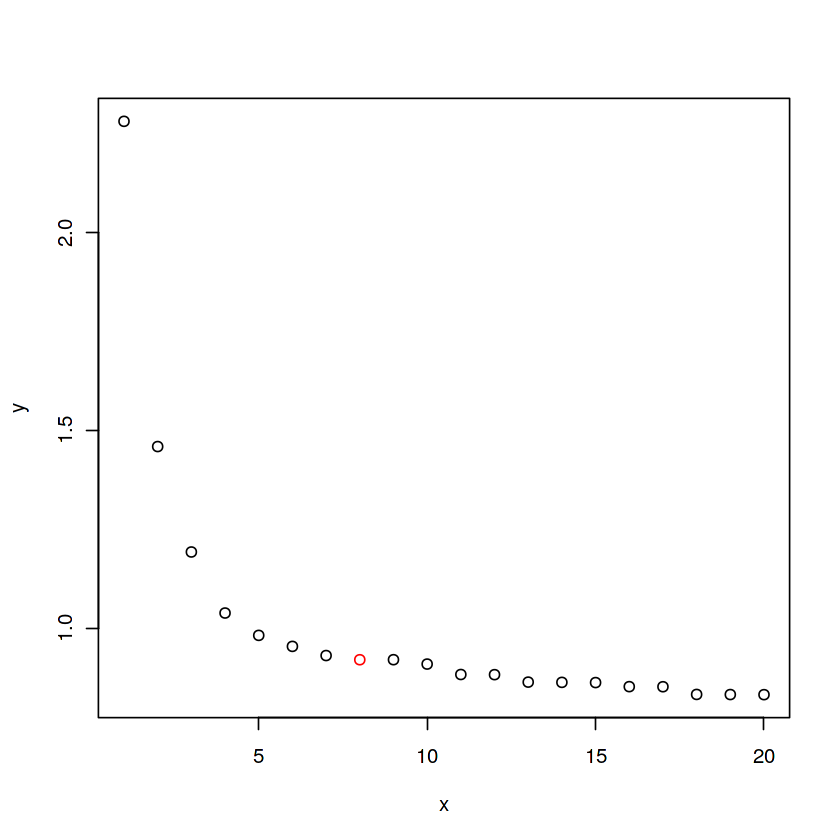

sl.bi
 -0.648397011545168  -0.342293222398773  -0.220252935754531 -0.0295584471482404 
                 52                  52                  52                  95 
 0.0445351646095824   0.187281265620426   0.489275913797731   0.998764055475874 
                  9                  52                  53                  51 
   3.50650289882905 
                 52 
[1] "Entropia = 3.08046355909237"


4           4           4           4           4           4 
-0.02955845 -0.02955845 -0.02955845 -0.02955845 -0.02955845 -0.02955845 
          4           9           4           9           6           8 
-0.02955845  3.50650290 -0.02955845  3.50650290  0.18728127  0.99876406 
          4           8           6           1           1           3 
-0.02955845  0.99876406  0.18728127 -0.64839701 -0.64839701 -0.22025294 
          9           8           1           4           8           6 
 3.50650290  0.99876406 -0.64839701 -0.02955845  0.99876406  0.18728127 
          2           2           3           6           4           1 
-0.34229322 -0.34229322 -0.22025294  0.18728127 -0.02955845 -0.64839701 
          2           3           2           6           9           6 
-0.34229322 -0.22025294 -0.34229322  0.18728127  3.50650290  0.18728127 
          3           7           4           7           1           9 
-0.22025294  0.48927591 -0.02955845  0.48927591 -0.64839701  3.50650290 
          9           3           1           2           9           3 
 3.50650290 -0.22025294 -0.64839701 -0.34229322  3.50650290 -0.22025294 
          2           1           1           2           4           4 
-0.34229322 -0.64839701 -0.64839701 -0.34229322 -0.02955845 -0.02955845 
          4           4           8           9           6           7 
-0.02955845 -0.02955845  0.99876406  3.50650290  0.18728127  0.48927591 
          7           7           9           7           1           2 
 0.48927591  0.48927591  3.50650290  0.48927591 -0.64839701 -0.34229322 
          1           6           9           8           2           5 
-0.64839701  0.18728127  3.50650290  0.99876406 -0.34229322  0.04453516 
          6           2           6           8           2           1 
 0.18728127 -0.34229322  0.18728127  0.99876406 -0.34229322 -0.64839701 
          2           8           6           4           4           4 
-0.34229322  0.99876406  0.18728127 -0.02955845 -0.02955845 -0.02955845 
          3           1           7           8           6           7 
-0.22025294 -0.64839701  0.48927591  0.99876406  0.18728127  0.48927591 
          2           7           7           1           6           9 
-0.34229322  0.48927591  0.48927591 -0.64839701  0.18728127  3.50650290 
          7           2           3           4           8           6 
 0.48927591 -0.34229322 -0.22025294 -0.02955845  0.99876406  0.18728127 
          3           6           4           4           4           4 
-0.22025294  0.18728127 -0.02955845 -0.02955845 -0.02955845 -0.02955845 
          4           4           8           7           9           7 
-0.02955845 -0.02955845  0.99876406  0.48927591  3.50650290  0.48927591 
          8           7           6           6           6           9 
 0.99876406  0.48927591  0.18728127  0.18728127  0.18728127  3.50650290 
          3           1           2           6           6           2 
-0.22025294 -0.64839701 -0.34229322  0.18728127  0.18728127 -0.34229322 
          3           6           1           1           4           9 
-0.22025294  0.18728127 -0.64839701 -0.64839701 -0.02955845  3.50650290 
          8           6           4           3           2           4 
 0.99876406  0.18728127 -0.02955845 -0.22025294 -0.34229322 -0.02955845 
          3           4           1           8           9           8 
-0.22025294 -0.02955845 -0.64839701  0.99876406  3.50650290  0.99876406 
          7           3           2           1           3           4 
 0.48927591 -0.22025294 -0.34229322 -0.64839701 -0.22025294 -0.02955845 
          9           9           8           1           3           8 
 3.50650290  3.50650290  0.99876406 -0.64839701 -0.22025294  0.99876406 
          4           4           4           4           9           8 
-0.02955845 -0.02955845 -0.02955845 -0.02955845  3.50650290  0.99876406 
          3           7           7           9           9         

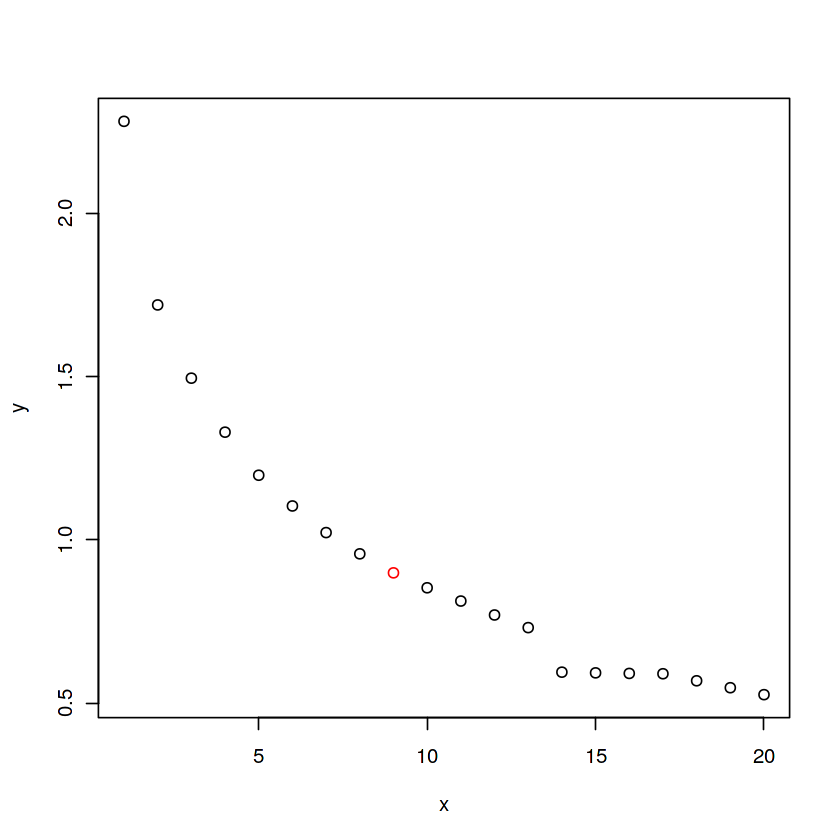

In [11]:
optimize_smoothing(smoothing_inter(n=20), agregado$percentage_change, agregado$health_region)

optimize_smoothing(smoothing_freq(n=20), agregado$percentage_change, agregado$health_region)

## ERRO!
# optimize_smoothing(smoothing_cluster(n=20), agregado$percentage_change, agregado$health_region)

Uma vez que as ótimas foram 8 (inter) e 9 (freq), vamos testar diferentes valores na faixa de 6 a 11.

<h4>Testando n = 6</h4>

sl.bi
-0.644464992459411 -0.159699256076034  0.224248759471061  0.617531309512821 
                53                198                 82                 48 
  1.04937560812711   3.29111016421517 
                29                 58 
[1] "Entropia = 3.12297907748201"
sl.bi
 -0.559117027716999   -0.24817841874865 -0.0295584471482404   0.166220365471285 
                 78                  78                  95                  61 
  0.593747151581085     2.7294161945684 
                 78                  78 
[1] "Entropia = 3.10125958253818"


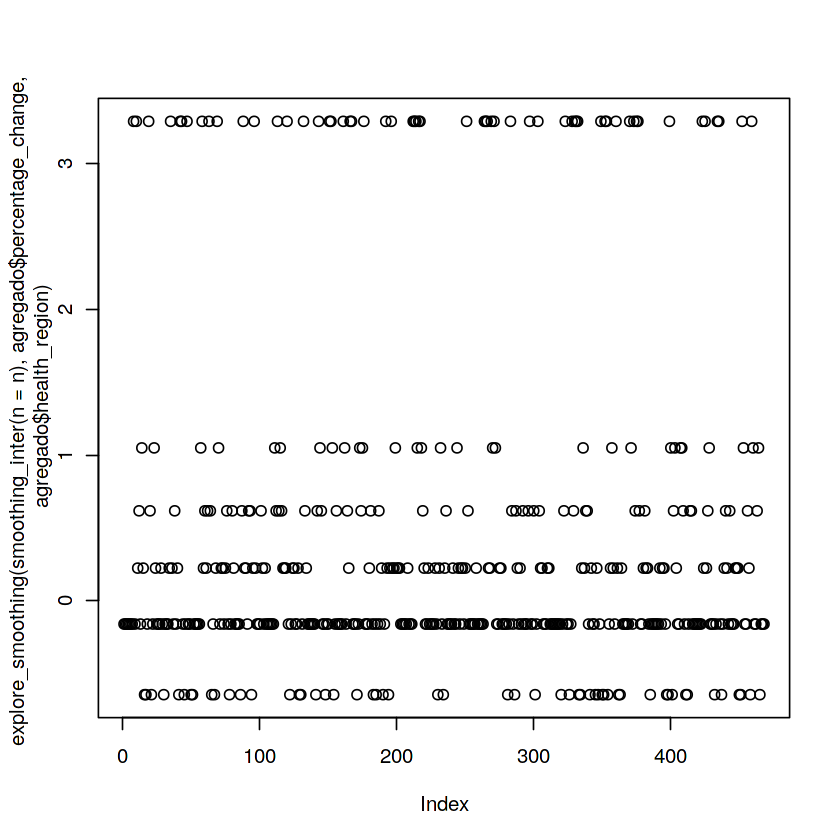

sl.bi
 -0.495345116971971 -0.0571472327857589   0.476169750833372    1.30423063968995 
                104                 184                  93                  52 
   2.65659140242474    8.15800865800866 
                 24                  11 
[1] "Entropia = 3.11453647628679"


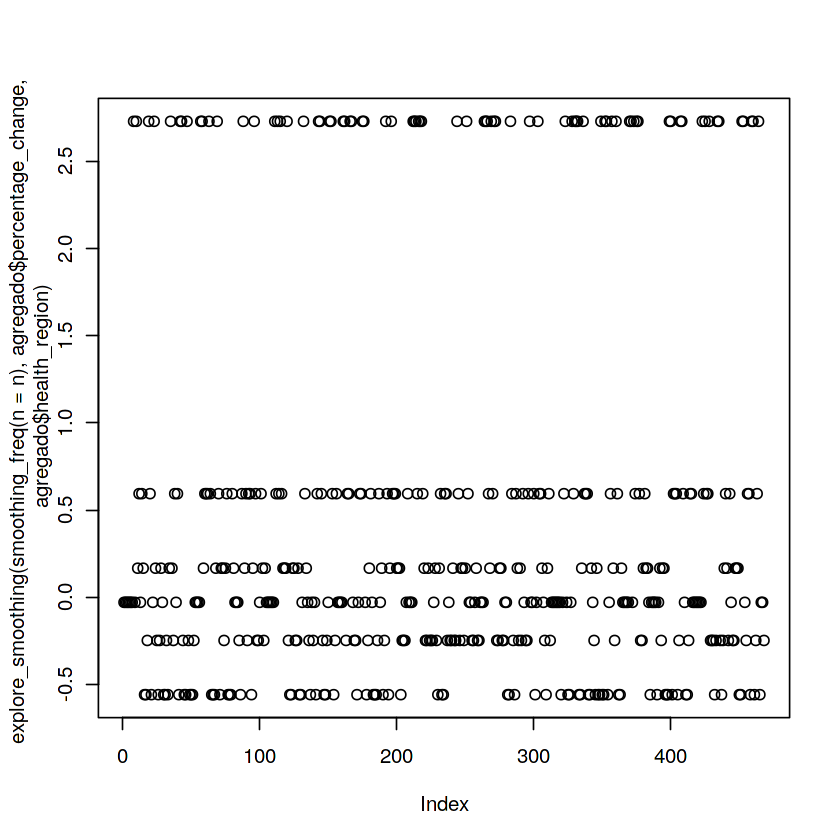

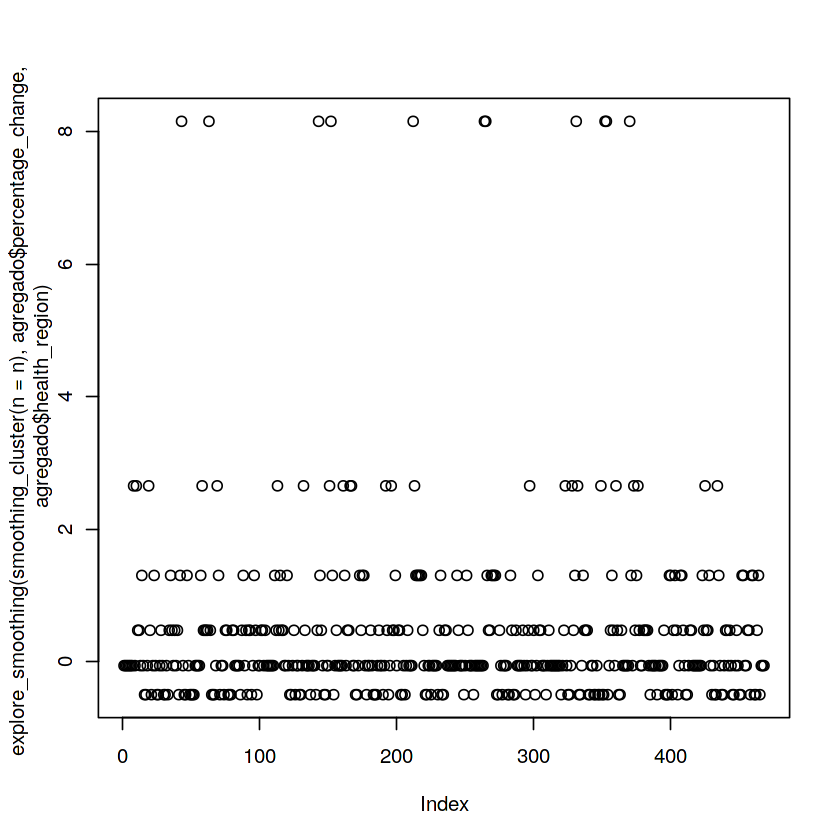

In [12]:
n <- 6

plot(explore_smoothing(smoothing_inter(n=n), agregado$percentage_change, agregado$health_region))

plot(explore_smoothing(smoothing_freq(n=n), agregado$percentage_change, agregado$health_region))

plot(explore_smoothing(smoothing_cluster(n=n), agregado$percentage_change, agregado$health_region))

A melhor distribuição parece freq, vamos utiliź-la:

In [13]:
agregado$representative <- explore_smoothing(smoothing_freq(n=n), agregado$percentage_change, agregado$health_region)

temp <- prepare.smoothing_freq(smoothing_freq(n=n), agregado$percentage_change)

quebras <- temp$interval.adj

agregado$factor <- cut(agregado$percentage_change, breaks = quebras, labels = letters[1:n], include.lowest=TRUE)

sl.bi
 -0.559117027716999   -0.24817841874865 -0.0295584471482404   0.166220365471285 
                 78                  78                  95                  61 
  0.593747151581085     2.7294161945684 
                 78                  78 
[1] "Entropia = 3.10125958253818"


Gráfico:

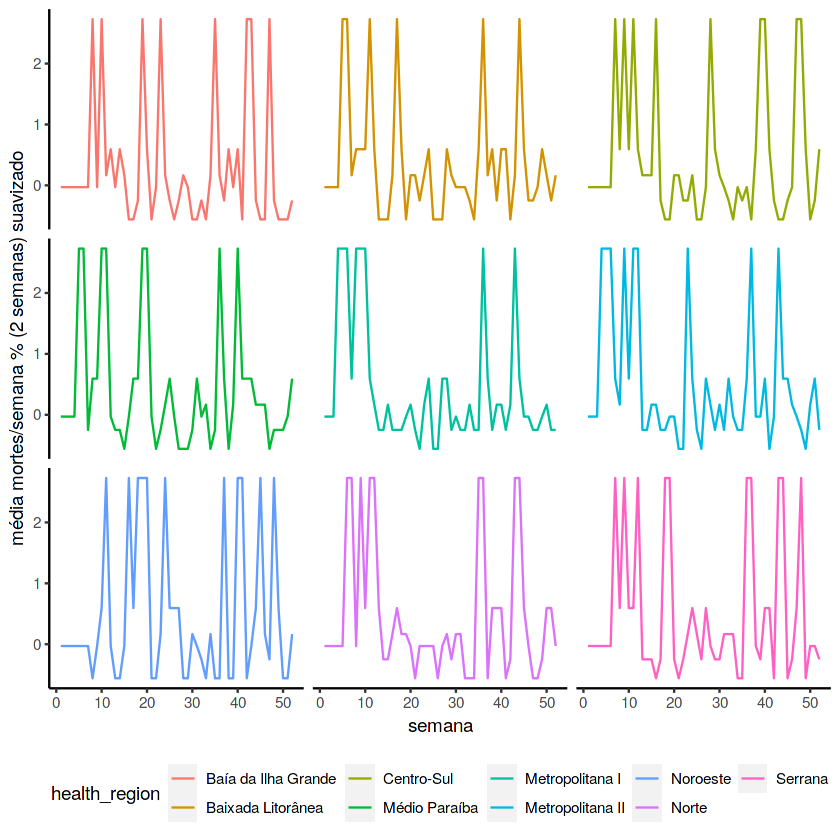

In [14]:
ggplot(agregado, aes(x=week, y=representative, group=health_region)) +
  geom_line(aes(color=health_region)) +
  labs(x = "semana", y = "média mortes/semana % (2 semanas) suavizado") +
  theme(legend.position="bottom", panel.background = element_blank(), axis.line = element_line(colour = "black"), strip.text = element_blank()) +
  facet_wrap(facets=.~health_region, nrow = 3, ncol=3)

<h4>Testando n = 7</h4>

sl.bi
-0.681340219608306 -0.286195005691829 0.0344480325538229  0.443788464030177 
                44                118                139                 60 
 0.842342599507338   1.20701792862656   3.36077196614625 
                38                 13                 56 
[1] "Entropia = 3.06781299752108"
sl.bi
 -0.593306522299203   -0.28754215558991 -0.0577797938874606   0.061710386084178 
                 67                  67                 117                  16 
  0.266350396174994   0.726720984588509     3.0122840985807 
                 67                  67                  67 
[1] "Entropia = 3.09866551750027"


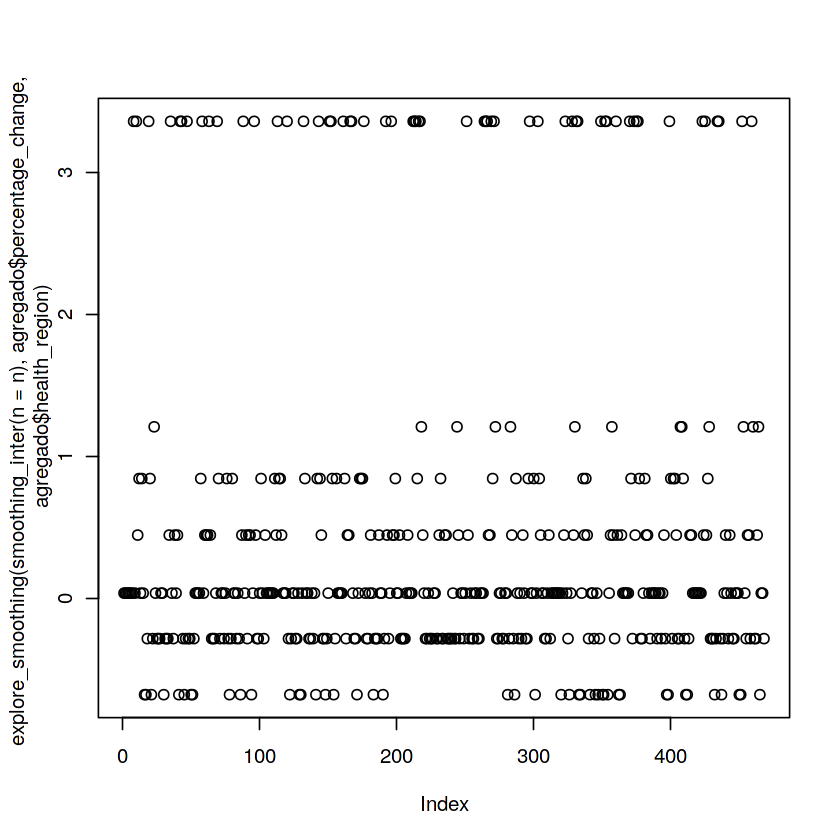

sl.bi
                -3 -0.586922994879395 -0.226495162101411  0.194364262459437 
                 1                 56                132                172 
  1.08033459300861   2.49544345269835   8.15800865800866 
                66                 30                 11 
[1] "Entropia = 3.09215352918684"


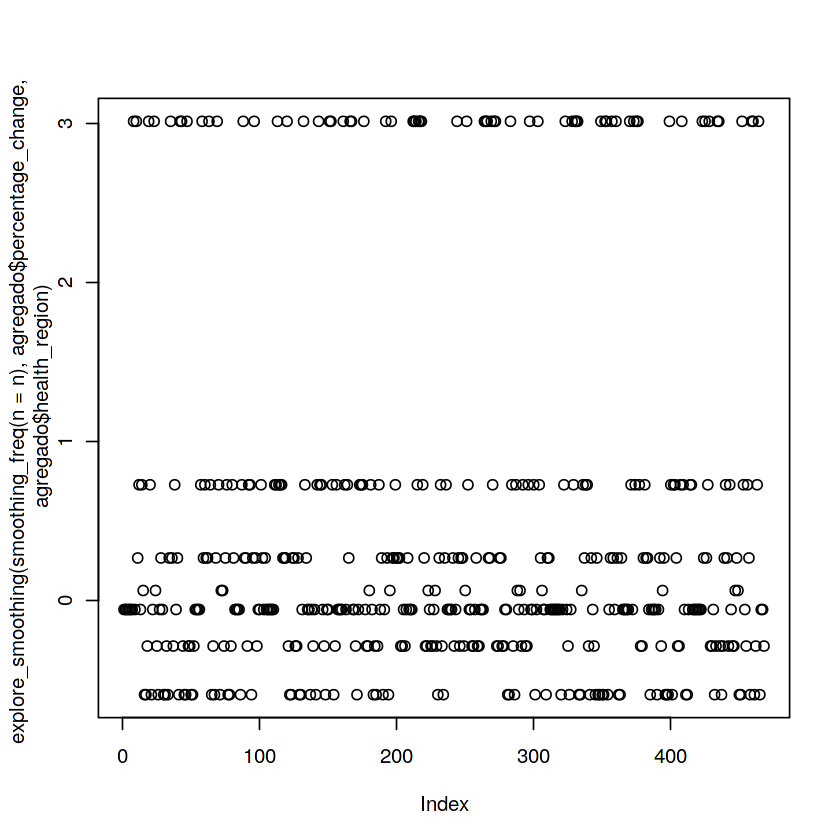

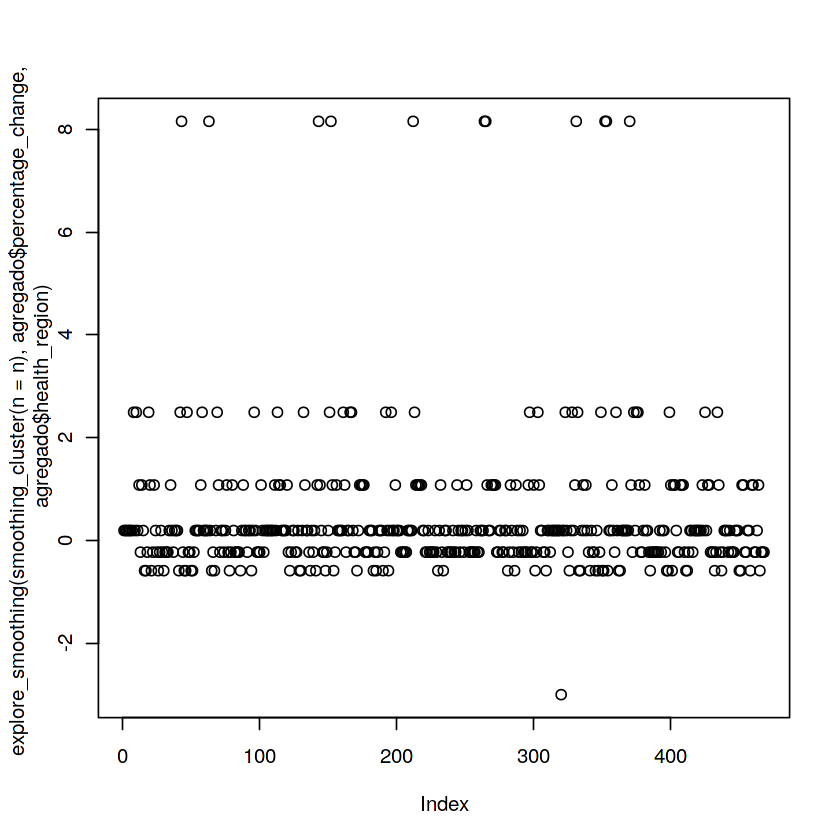

In [15]:
n <- 7

plot(explore_smoothing(smoothing_inter(n=n), agregado$percentage_change, agregado$health_region))

plot(explore_smoothing(smoothing_freq(n=n), agregado$percentage_change, agregado$health_region))

plot(explore_smoothing(smoothing_cluster(n=n), agregado$percentage_change, agregado$health_region))

A melhor distribuição parece freq, vamos utiliź-la:

In [16]:
agregado$representative <- explore_smoothing(smoothing_freq(n=n), agregado$percentage_change, agregado$health_region)

temp <- prepare.smoothing_freq(smoothing_freq(n=n), agregado$percentage_change)

quebras <- temp$interval.adj

agregado$factor <- cut(agregado$percentage_change, breaks = quebras, labels = letters[1:n], include.lowest=TRUE)

sl.bi
 -0.593306522299203   -0.28754215558991 -0.0577797938874606   0.061710386084178 
                 67                  67                 117                  16 
  0.266350396174994   0.726720984588509     3.0122840985807 
                 67                  67                  67 
[1] "Entropia = 3.09866551750027"


Gráfico:

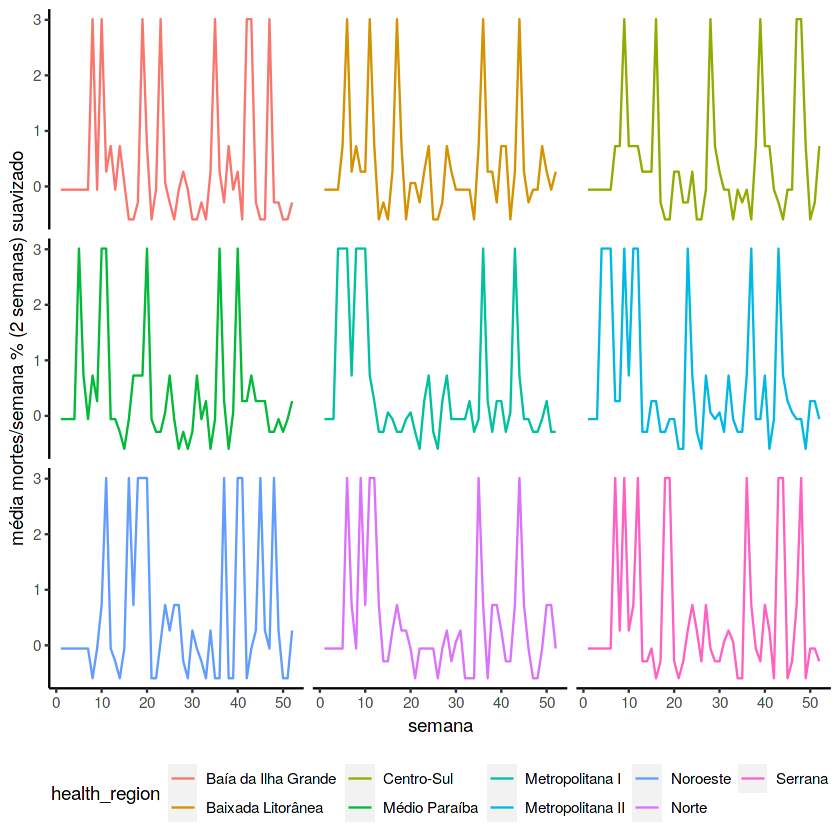

In [17]:
ggplot(agregado, aes(x=week, y=representative, group=health_region)) +
  geom_line(aes(color=health_region)) +
  labs(x = "semana", y = "média mortes/semana % (2 semanas) suavizado") +
  theme(legend.position="bottom", panel.background = element_blank(), axis.line = element_line(colour = "black"), strip.text = element_blank()) +
  facet_wrap(facets=.~health_region, nrow = 3, ncol=3)

<h4>Testando n = 8</h4>

sl.bi
 -0.730995336989331  -0.339274661356296 -0.0355804755364314   0.277214796100946 
                 34                 102                 136                  61 
   0.59634194826929   0.939681865451803     1.2507244491338    3.39662438573275 
                 43                  25                  12                  55 
[1] "Entropia = 3.07175213202694"
sl.bi
  -0.610808495768328   -0.304319200265858   -0.164178578061456 
                  62                   61                   53 
-0.00856046283056794    0.115733985010759    0.391469633817463 
                  75                   42                   58 
   0.855023789844427      3.2574362262808 
                  58                   59 
[1] "Entropia = 3.0601777397556"


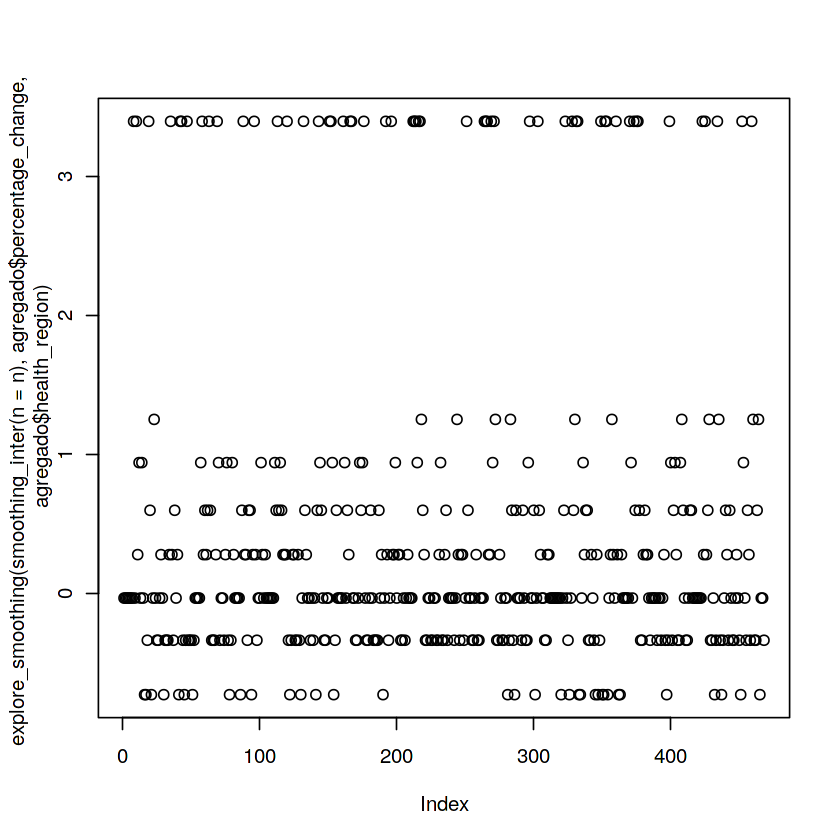

sl.bi
                -3 -0.586922994879395 -0.226495162101411  0.194364262459437 
                 1                 56                132                172 
  1.08033459300861   2.49544345269835   7.37380952380952                 16 
                66                 30                 10                  1 
[1] "Entropia = 3.08770998355869"


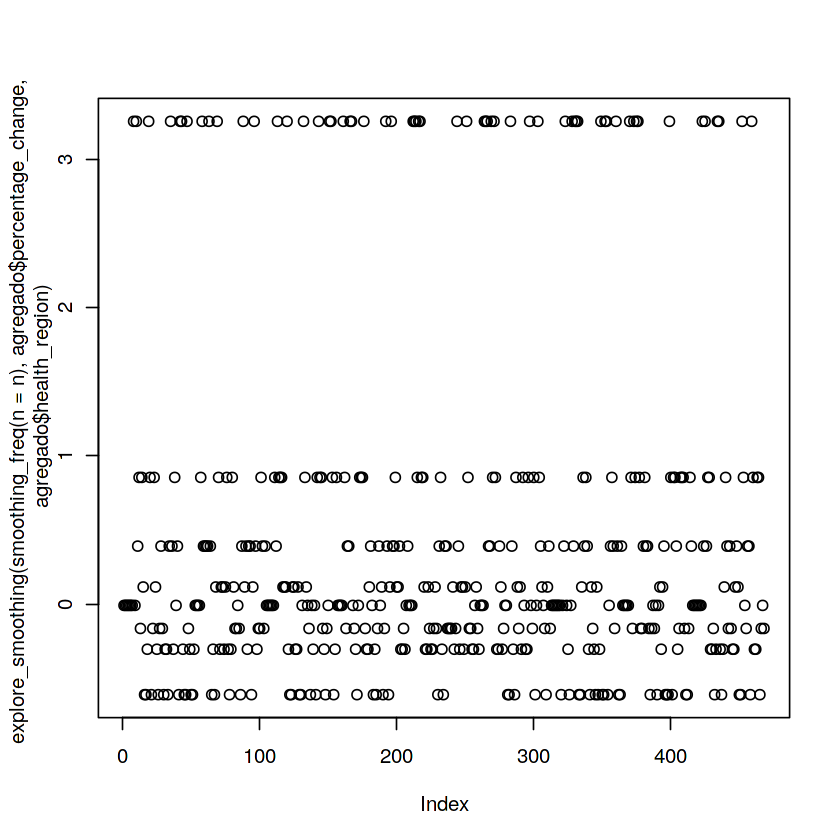

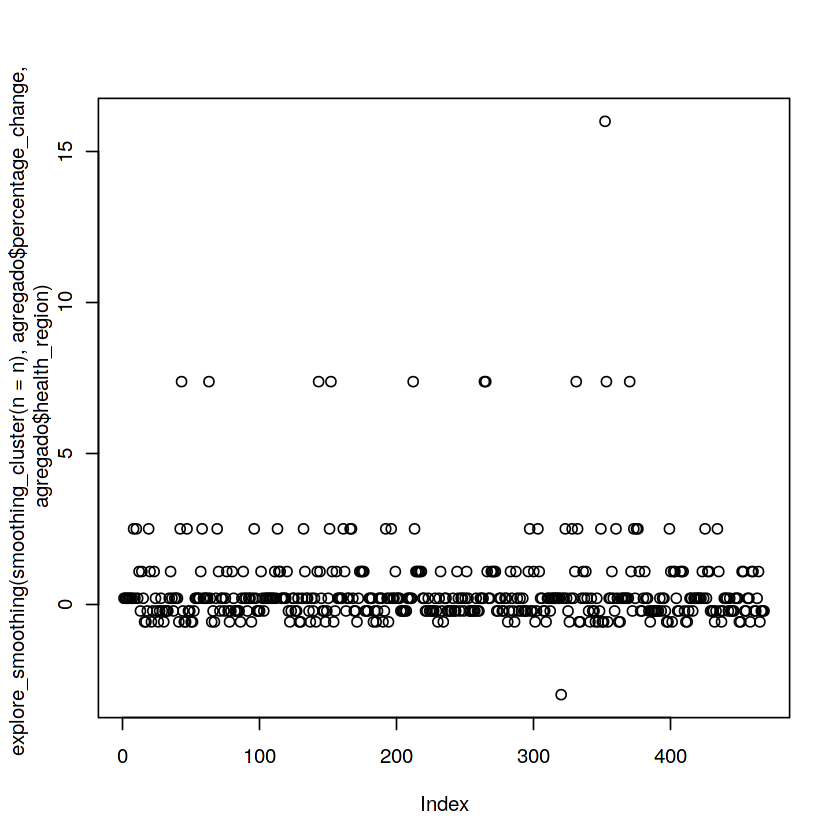

In [18]:
n <- 8

plot(explore_smoothing(smoothing_inter(n=n), agregado$percentage_change, agregado$health_region))

plot(explore_smoothing(smoothing_freq(n=n), agregado$percentage_change, agregado$health_region))

plot(explore_smoothing(smoothing_cluster(n=n), agregado$percentage_change, agregado$health_region))

A melhor distribuição parece freq, vamos utiliź-la:

In [19]:
agregado$representative <- explore_smoothing(smoothing_freq(n=n), agregado$percentage_change, agregado$health_region)

temp <- prepare.smoothing_freq(smoothing_freq(n=n), agregado$percentage_change)

quebras <- temp$interval.adj

agregado$factor <- cut(agregado$percentage_change, breaks = quebras, labels = letters[1:n], include.lowest=TRUE)

sl.bi
  -0.610808495768328   -0.304319200265858   -0.164178578061456 
                  62                   61                   53 
-0.00856046283056794    0.115733985010759    0.391469633817463 
                  75                   42                   58 
   0.855023789844427      3.2574362262808 
                  58                   59 
[1] "Entropia = 3.0601777397556"


Gráfico:

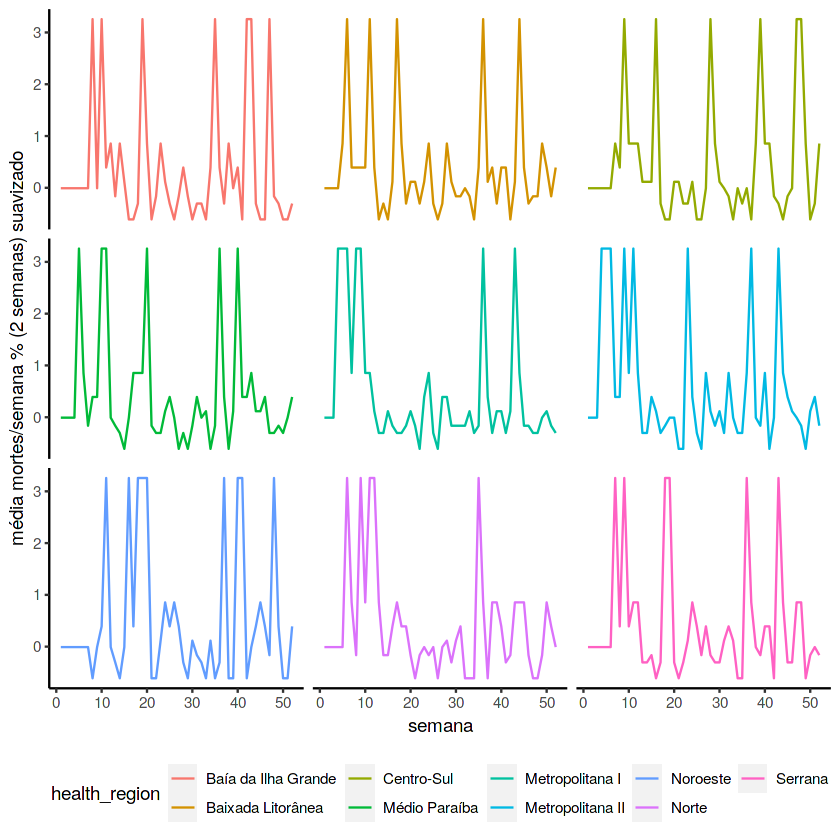

In [20]:
ggplot(agregado, aes(x=week, y=representative, group=health_region)) +
  geom_line(aes(color=health_region)) +
  labs(x = "semana", y = "média mortes/semana % (2 semanas) suavizado") +
  theme(legend.position="bottom", panel.background = element_blank(), axis.line = element_line(colour = "black"), strip.text = element_blank()) +
  facet_wrap(facets=.~health_region, nrow = 3, ncol=3)

<h4>Testando n = 9</h4>

sl.bi
-0.773982745341665 -0.407173344040898 -0.104380756550815  0.146885527513516 
                27                 71                153                 54 
 0.437857112783599  0.700201038782023  0.990223373723901    1.2717026722939 
                50                 26                 22                 10 
  3.39662438573275 
                55 
[1] "Entropia = 3.04339229201504"
sl.bi
 -0.648397011545168  -0.342293222398773  -0.220252935754531 -0.0295584471482404 
                 52                  52                  52                  95 
 0.0445351646095824   0.187281265620426   0.489275913797731   0.998764055475874 
                  9                  52                  53                  51 
   3.50650289882905 
                 52 
[1] "Entropia = 3.08046355909237"


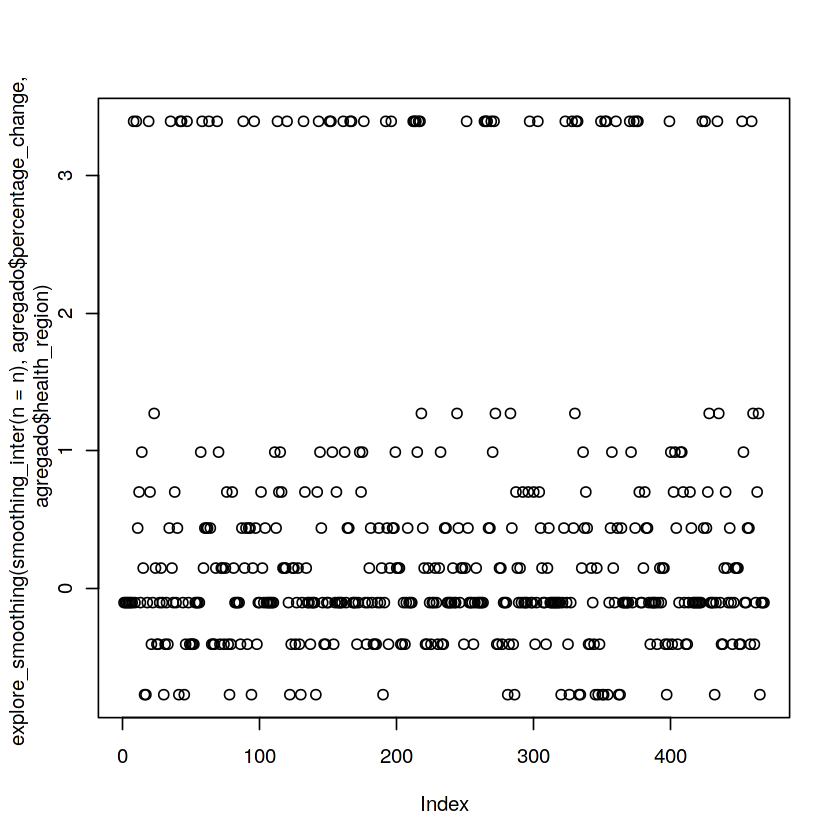

sl.bi
                -3 -0.589974001203405 -0.251665305690854  0.080661835374972 
                 1                 55                117                146 
 0.686192657871013   1.68222824919693   3.17940521017444   7.37380952380952 
                85                 40                 13                 10 
                16 
                 1 
[1] "Entropia = 3.06748231551436"


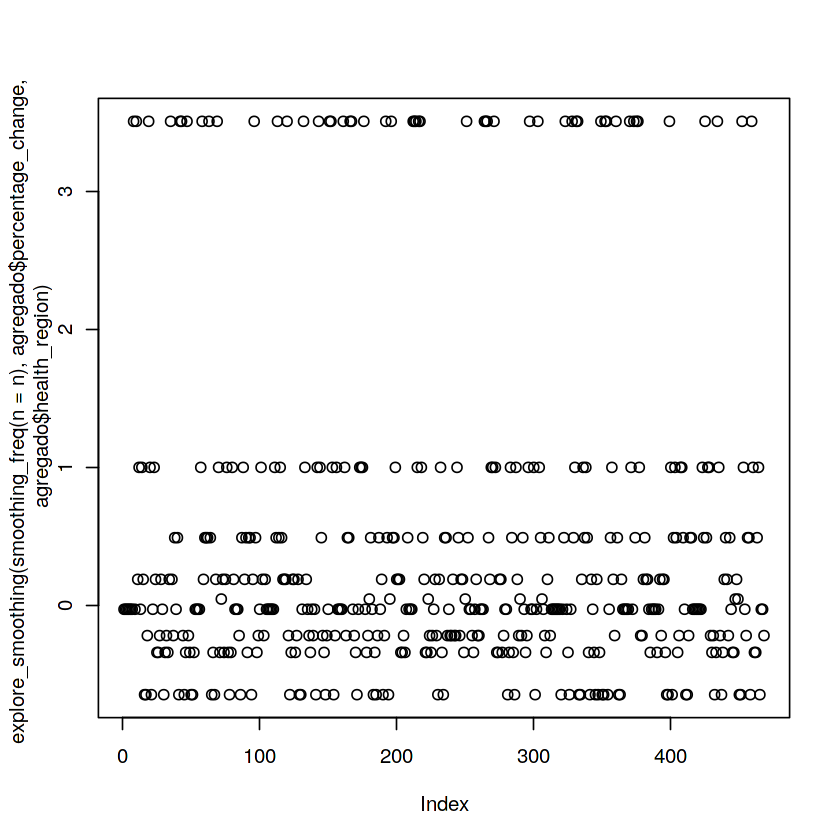

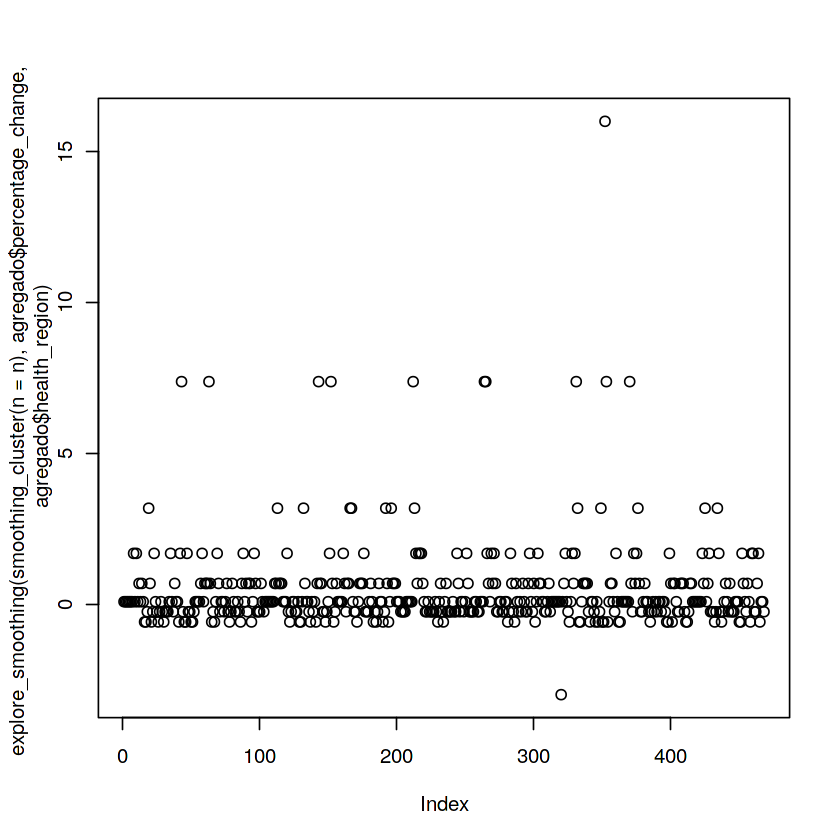

In [21]:
n <- 9

plot(explore_smoothing(smoothing_inter(n=n), agregado$percentage_change, agregado$health_region))

plot(explore_smoothing(smoothing_freq(n=n), agregado$percentage_change, agregado$health_region))

plot(explore_smoothing(smoothing_cluster(n=n), agregado$percentage_change, agregado$health_region))

A melhor distribuição parece freq, vamos utiliź-la:

In [22]:
agregado$representative <- explore_smoothing(smoothing_freq(n=n), agregado$percentage_change, agregado$health_region)

temp <- prepare.smoothing_freq(smoothing_freq(n=n), agregado$percentage_change)

quebras <- temp$interval.adj

agregado$factor <- cut(agregado$percentage_change, breaks = quebras, labels = letters[1:n], include.lowest=TRUE)

sl.bi
 -0.648397011545168  -0.342293222398773  -0.220252935754531 -0.0295584471482404 
                 52                  52                  52                  95 
 0.0445351646095824   0.187281265620426   0.489275913797731   0.998764055475874 
                  9                  52                  53                  51 
   3.50650289882905 
                 52 
[1] "Entropia = 3.08046355909237"


Gráfico:

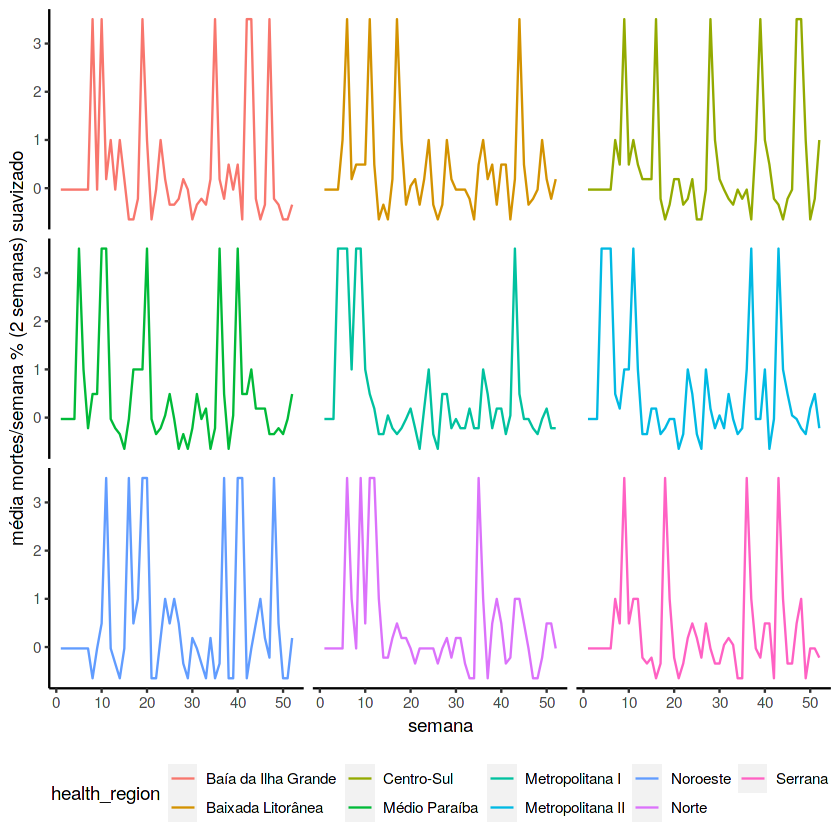

In [23]:
ggplot(agregado, aes(x=week, y=representative, group=health_region)) +
  geom_line(aes(color=health_region)) +
  labs(x = "semana", y = "média mortes/semana % (2 semanas) suavizado") +
  theme(legend.position="bottom", panel.background = element_blank(), axis.line = element_line(colour = "black"), strip.text = element_blank()) +
  facet_wrap(facets=.~health_region, nrow = 3, ncol=3)

<h4>Testando n = 10</h4>

sl.bi
-0.813811672139516 -0.468497881706772 -0.228562264608038  0.021999621647056 
                22                 52                 99                113 
 0.319547969343053  0.563363244620231  0.826152024196599   1.06407052310704 
                47                 35                 21                 18 
  1.34277982741533    3.4321879766502 
                 7                 54 
[1] "Entropia = 3.0169305561669"
sl.bi
  -0.668796191670663   -0.364233334976793   -0.251773184061576 
                  47                   48                   46 
  -0.113158881001948 -0.00115001911053304   0.0867623422376178 
                  46                   64                   30 
   0.288040200702059    0.571118263967298      1.1195117885202 
                  46                   48                   46 
    3.71451584790694 
                  47 
[1] "Entropia = 3.03904663510439"


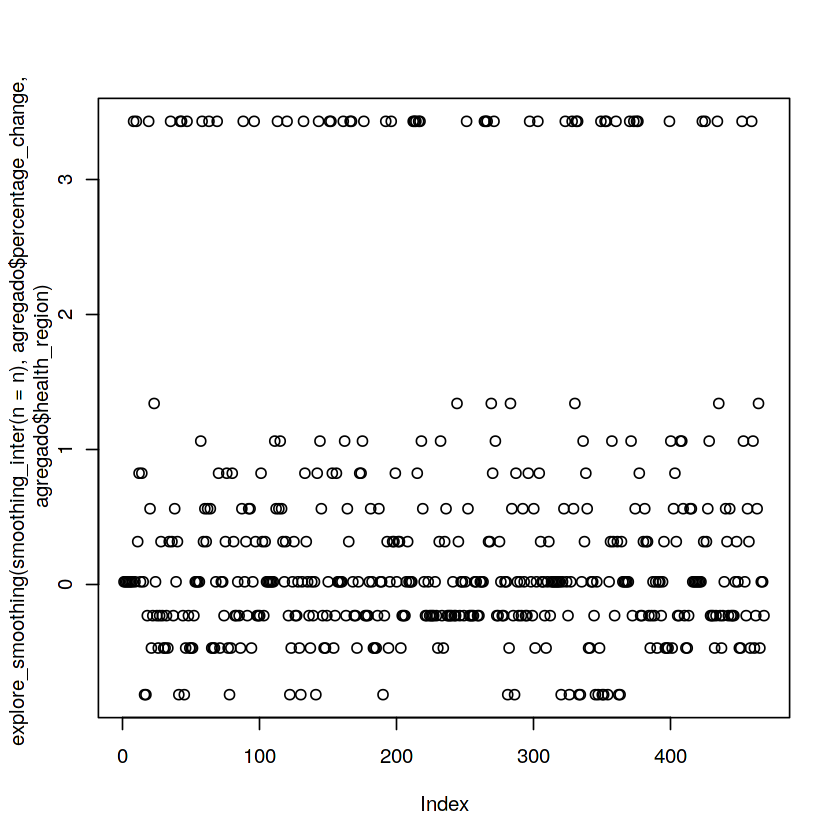

sl.bi
                -3 -0.648080261155823 -0.370328335674052 -0.176475640070112 
                 1                 37                 67                 78 
 0.091465332434738  0.686192657871013   1.68222824919693   3.17940521017444 
               136                 85                 40                 13 
  7.37380952380952                 16 
                10                  1 
[1] "Entropia = 3.04120529784991"


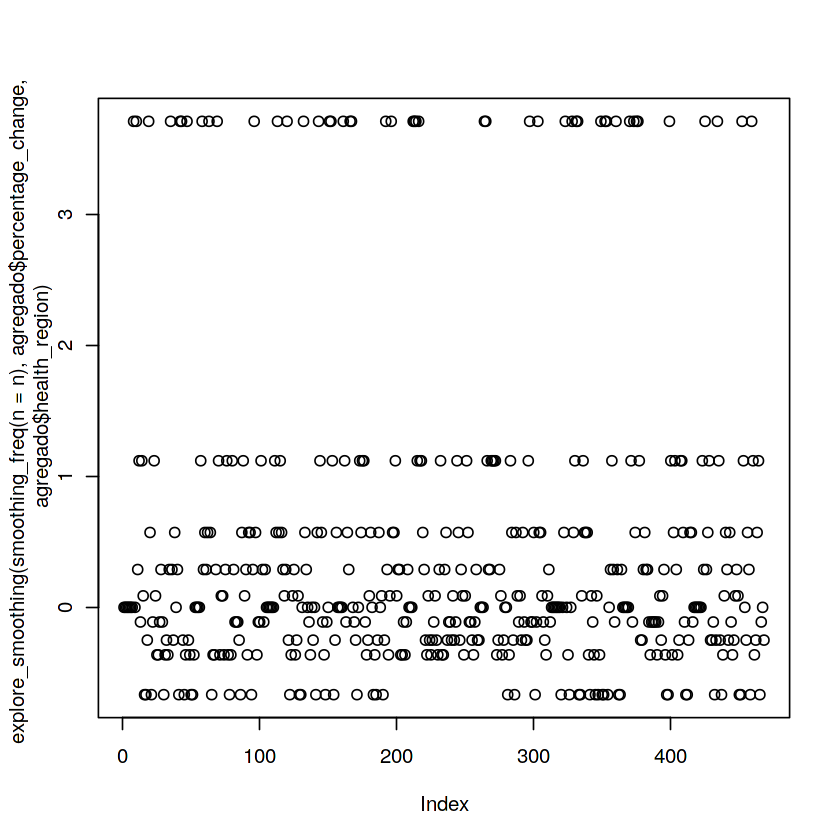

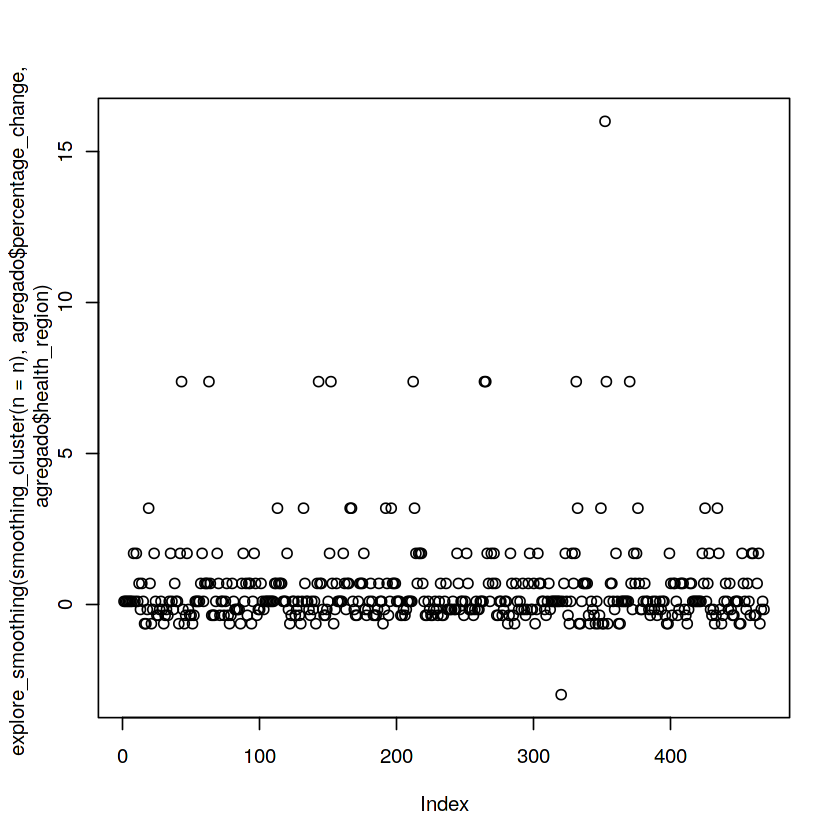

In [24]:
n <- 10

plot(explore_smoothing(smoothing_inter(n=n), agregado$percentage_change, agregado$health_region))

plot(explore_smoothing(smoothing_freq(n=n), agregado$percentage_change, agregado$health_region))

plot(explore_smoothing(smoothing_cluster(n=n), agregado$percentage_change, agregado$health_region))

A melhor distribuição parece freq, vamos utiliź-la:

In [25]:
agregado$representative <- explore_smoothing(smoothing_freq(n=n), agregado$percentage_change, agregado$health_region)

temp <- prepare.smoothing_freq(smoothing_freq(n=n), agregado$percentage_change)

quebras <- temp$interval.adj

agregado$factor <- cut(agregado$percentage_change, breaks = quebras, labels = letters[1:n], include.lowest=TRUE)

sl.bi
  -0.668796191670663   -0.364233334976793   -0.251773184061576 
                  47                   48                   46 
  -0.113158881001948 -0.00115001911053304   0.0867623422376178 
                  46                   64                   30 
   0.288040200702059    0.571118263967298      1.1195117885202 
                  46                   48                   46 
    3.71451584790694 
                  47 
[1] "Entropia = 3.03904663510439"


Gráfico:

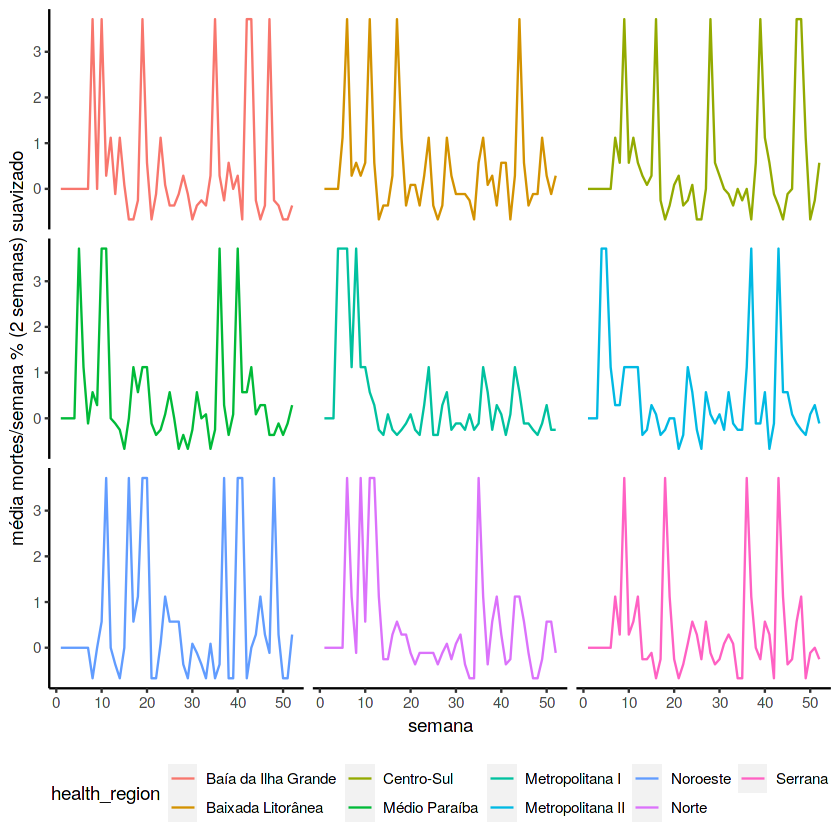

In [26]:
ggplot(agregado, aes(x=week, y=representative, group=health_region)) +
  geom_line(aes(color=health_region)) +
  labs(x = "semana", y = "média mortes/semana % (2 semanas) suavizado") +
  theme(legend.position="bottom", panel.background = element_blank(), axis.line = element_line(colour = "black"), strip.text = element_blank()) +
  facet_wrap(facets=.~health_region, nrow = 3, ncol=3)